In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch

def view_correlation(df, save=False):
    columns_to_exclude = ["image ID", "method", "attack", "true class", "predicted class", "original score", "adversarial score", "number of regions original",
                          "number of regions adversarial"]
    df_numeric = df.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=np.number)
    
    if df_numeric.empty or df_numeric.shape[1] < 2:
        print("Not enough numeric columns found for correlation analysis after exclusions.")
        return

    correlation_matrix = df_numeric.corr(method="pearson")

        # Compute linkage from distance = 1 - abs(corr)
    pairwise_distances = 1 - correlation_matrix
    linkage = sch.linkage(pairwise_distances, method="average")

    # Get order of leaves (metric indices)
    dendro = sch.dendrogram(linkage, no_plot=True)
    ordered_cols = [correlation_matrix.columns[i] for i in dendro["leaves"]]

    # Reorder correlation matrix
    correlation_matrix = correlation_matrix.loc[ordered_cols, ordered_cols]

    plt.figure(figsize=(10, 8))
    
    # Use seaborn heatmap which handles labels better
    ax = sns.heatmap(correlation_matrix, 
                     annot=True, 
                     fmt='.2f', 
                     cmap='coolwarm', 
                     center=0,
                     square=True,
                     cbar_kws={'shrink': 0.8})
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.title("Correlation matrix of saliency map metrics", pad=10)
    plt.tight_layout()

    if save:
        plt.savefig("latex/img/untargeted_correlation_matrix.svg", format='svg')
    plt.show()

    upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
    print("Highly correlated metrics:", to_drop)

    reduced_df = df_numeric.drop(columns=to_drop, errors='ignore')
    if reduced_df.empty or reduced_df.shape[1] < 2:
        print("No columns remaining or not enough columns after dropping highly correlated ones for reduced matrix.")
        return
        
    corr_reduced = reduced_df.corr(method="pearson")

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_reduced,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Pearson r"},
    )
    plt.title("Korrelationsmatrix nach Entfernen hoch korrelierter Metriken")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [7]:
results_df = pd.read_csv("results/big_dataset/untargeted/cam_comparison_metrics_combined.csv")

In [8]:
metric_cols = [
    'mean pixel difference', 'percentage of different pixels', 'number of regions difference', 'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM', 'Spearman\'s rank coefficient'
]

In [9]:
## check correlation of Linf Repeated Additive Uniform Noise attack iamges mean difference and metrics
linf_df = results_df[results_df["attack"] == "Linf Repeated Additive Uniform Noise"]
linf_df[metric_cols].corr(method="pearson")

,mean pixel difference,percentage of different pixels,number of regions difference,cosine similarity,activation ratio,JS divergence,important activation ratio,intersection over union,SSIM,Spearman's rank coefficient
mean pixel difference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percentage of different pixels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number of regions difference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cosine similarity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activation ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JS divergence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
important activation ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
intersection over union,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSIM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spearman's rank coefficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
## for all atacks in attack column, check correlation of images mean difference and metrics, print if correlation between image mean difference and any metric (except itself) is above 0.8
for attack in results_df["attack"].unique():
    attack_df = results_df[results_df["attack"] == attack]
    corr = attack_df[metric_cols + ["images mean difference"]].corr(method="pearson")

    # Exclude the self-correlation entry
    corr_vals = corr["images mean difference"].drop("images mean difference")
    high_corr = corr_vals[abs(corr_vals) > 0.8]
    if not high_corr.empty:
        print(f"High correlation found for {attack}:")
        print(high_corr)

In [11]:
## for all attacks, check if the correlation between metrics is similar for all attacks (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.2

for attack in results_df["attack"].unique():
    attack_df = results_df[results_df["attack"] == attack]
    corr = attack_df[metric_cols].corr(method="pearson")

    # Check if the absolute difference between the correlation matrices is less than the threshold

    # Compute absolute difference matrix
    diff = abs(corr_matrix - corr)

    # Create a boolean mask of significant deviations
    deviation_mask = diff >= deviation_threshold

    # Optional: print the locations and values of deviations
    if deviation_mask.any().any():
        print(f"Correlation for {attack} deviates significantly at the following entries:")
        print(diff[deviation_mask])

Correlation for Salt And Pepper Noise deviates significantly at the following entries:
                                mean pixel difference  \
mean pixel difference                             NaN   
percentage of different pixels                    NaN   
number of regions difference                      NaN   
cosine similarity                                 NaN   
activation ratio                                  NaN   
JS divergence                                     NaN   
important activation ratio                        NaN   
intersection over union                           NaN   
SSIM                                              NaN   
Spearman's rank coefficient                       NaN   

                                percentage of different pixels  \
mean pixel difference                                      NaN   
percentage of different pixels                             NaN   
number of regions difference                               NaN   
cosine similarity    

In [12]:
## for all methods in method column, check if the correlation between metrics is similar for all methods (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.2

for method in results_df["method"].unique():
    method_df = results_df[results_df["method"] == method]
    corr = method_df[metric_cols].corr(method="pearson")

    # Check if the absolute difference between the correlation matrices is less than the threshold

    # Compute absolute difference matrix
    diff = abs(corr_matrix - corr)

    # Create a boolean mask of significant deviations
    deviation_mask = diff >= deviation_threshold
    deviations = diff[deviation_mask]

    # Optional: print the locations and values of deviations
    if deviation_mask.any().any():
        print(f"Correlation for {method} deviates significantly at the following entries:")
        for (row, col), value in deviations.stack().items():
            val1 = corr_matrix.loc[row, col]
            val2 = corr.loc[row, col]
            print(f"Deviation at ({row}, {col}): {val1:.3f} vs {val2:.3f} → Δ = {abs(val1 - val2):.3f}")

Correlation for GradCAM++ deviates significantly at the following entries:
Deviation at (mean pixel difference, important activation ratio): 0.294 vs 0.090 → Δ = 0.204
Deviation at (activation ratio, important activation ratio): 0.226 vs -0.030 → Δ = 0.256
Deviation at (important activation ratio, mean pixel difference): 0.294 vs 0.090 → Δ = 0.204
Deviation at (important activation ratio, activation ratio): 0.226 vs -0.030 → Δ = 0.256
Correlation for EigenGradCAM deviates significantly at the following entries:
Deviation at (mean pixel difference, important activation ratio): 0.294 vs 0.609 → Δ = 0.315
Deviation at (percentage of different pixels, important activation ratio): 0.209 vs 0.461 → Δ = 0.252
Deviation at (important activation ratio, mean pixel difference): 0.294 vs 0.609 → Δ = 0.315
Deviation at (important activation ratio, percentage of different pixels): 0.209 vs 0.461 → Δ = 0.252
Correlation for LayerCAM deviates significantly at the following entries:
Deviation at (activ

In [13]:
# for all combinations of attack and method, check if the correlation between metrics is similar for all combinations (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.4

for attack in results_df["attack"].unique():
    for method in results_df["method"].unique():
        subset_df = results_df[(results_df["attack"] == attack) & (results_df["method"] == method)]
        if subset_df.empty:
            continue
        corr = subset_df[metric_cols].corr(method="pearson")

        # Check if the absolute difference between the correlation matrices is less than the threshold

        # Compute absolute difference matrix
        diff = abs(corr_matrix - corr)

        # Create a boolean mask of significant deviations
        deviation_mask = diff >= deviation_threshold
        deviations = diff[deviation_mask]

        # Print only the deviating entries with labels and formatted values
        
        # Optional: print the locations and values of deviations
        if deviation_mask.any().any():
            print(f"Correlation for {attack} with method {method} deviates significantly at the following entries:")
            for (row, col), value in deviations.stack().items():
                val1 = corr_matrix.loc[row, col]
                val2 = corr.loc[row, col]
                print(f"Deviation at ({row}, {col}): {val1:.3f} vs {val2:.3f} → Δ = {abs(val1 - val2):.3f}")

Correlation for L2 Proj. Gradient Descent (PGD) with method EigenGradCAM deviates significantly at the following entries:
Deviation at (mean pixel difference, important activation ratio): 0.294 vs 0.712 → Δ = 0.418
Deviation at (important activation ratio, mean pixel difference): 0.294 vs 0.712 → Δ = 0.418
Correlation for Linf Basic Iterative Method (BIM) with method AblationCAM deviates significantly at the following entries:
Deviation at (activation ratio, JS divergence): -0.031 vs -0.441 → Δ = 0.410
Deviation at (JS divergence, activation ratio): -0.031 vs -0.441 → Δ = 0.410
Correlation for DDN Attack with method EigenGradCAM deviates significantly at the following entries:
Deviation at (mean pixel difference, important activation ratio): 0.294 vs 0.725 → Δ = 0.431
Deviation at (important activation ratio, mean pixel difference): 0.294 vs 0.725 → Δ = 0.431
Correlation for L2 Basic Iterative Method (BIM) with method EigenGradCAM deviates significantly at the following entries:
Deviat

/var/folders/1w/ytjjn1392fd518g9vmt57xl80000gn/T/ipykernel_6239/1488271169.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(pairwise_distances, method="average")


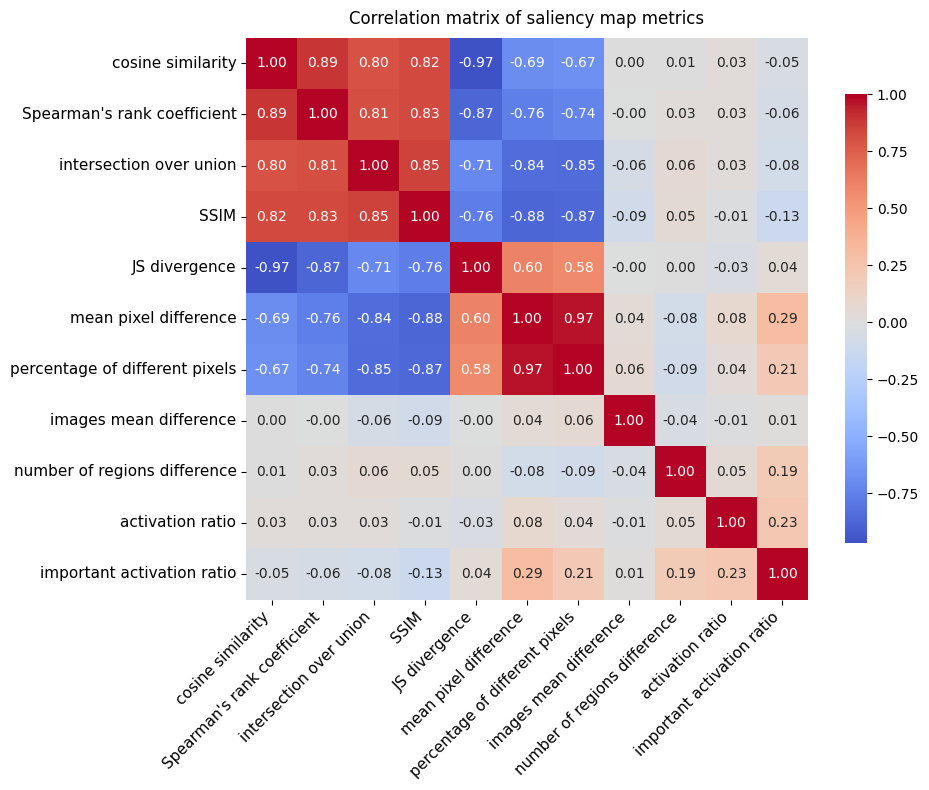

Highly correlated metrics: ["Spearman's rank coefficient", 'intersection over union', 'SSIM', 'JS divergence', 'mean pixel difference', 'percentage of different pixels']


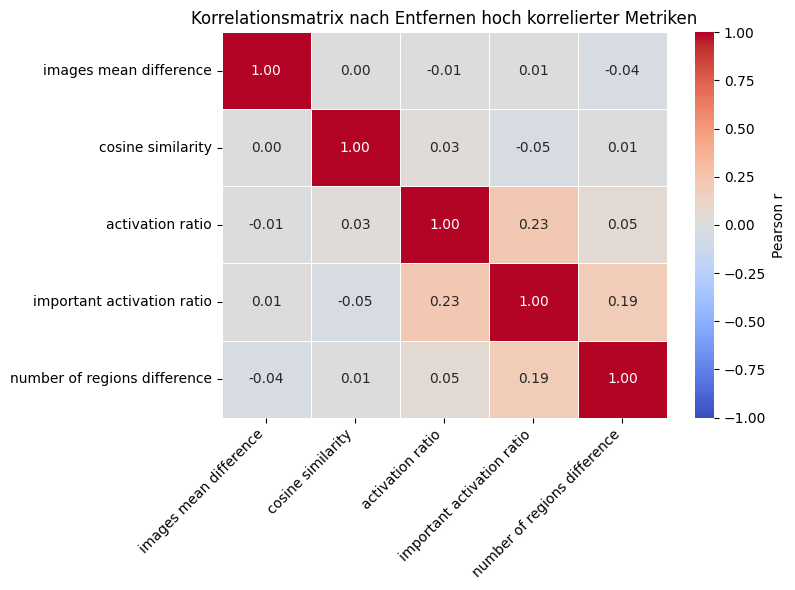

In [14]:
view_correlation(results_df, save=True)

In [16]:
# List of metric columns
metric_cols = [
    'mean pixel difference', 'percentage of different pixels', 'number of regions difference', 'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM', 'Spearman\'s rank coefficient'
]

In [19]:
results_df[results_df["method"] == "FullGrad"]["activation ratio"].describe()

count    6.722900e+04
mean     1.000000e+00
std      9.444175e-07
min      9.999801e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000020e+00
Name: activation ratio, dtype: float64

In [20]:
results_df[results_df["method"] == "FullGrad"]["mean pixel difference"].describe()

count    67229.000000
mean         0.125939
std          0.055475
min          0.000488
25%          0.086875
50%          0.116030
75%          0.153668
max          0.451885
Name: mean pixel difference, dtype: float64

## Check for differences in metrics per explanation method and per attack

It is interesting to see which attacks give the same results for each explanation method and how they differ. this can be achieved with statistical tests (kruskal test) and post-hoc analysis. The kruskal test checks whether the rank-order of the metric is the same for all attacks, given a specific explanation method. If this test is significant (< 0.05), then at least 2 attacks have significantly different metrics. To see which of the attacks differ, a post-hoc-dunn test can be done.

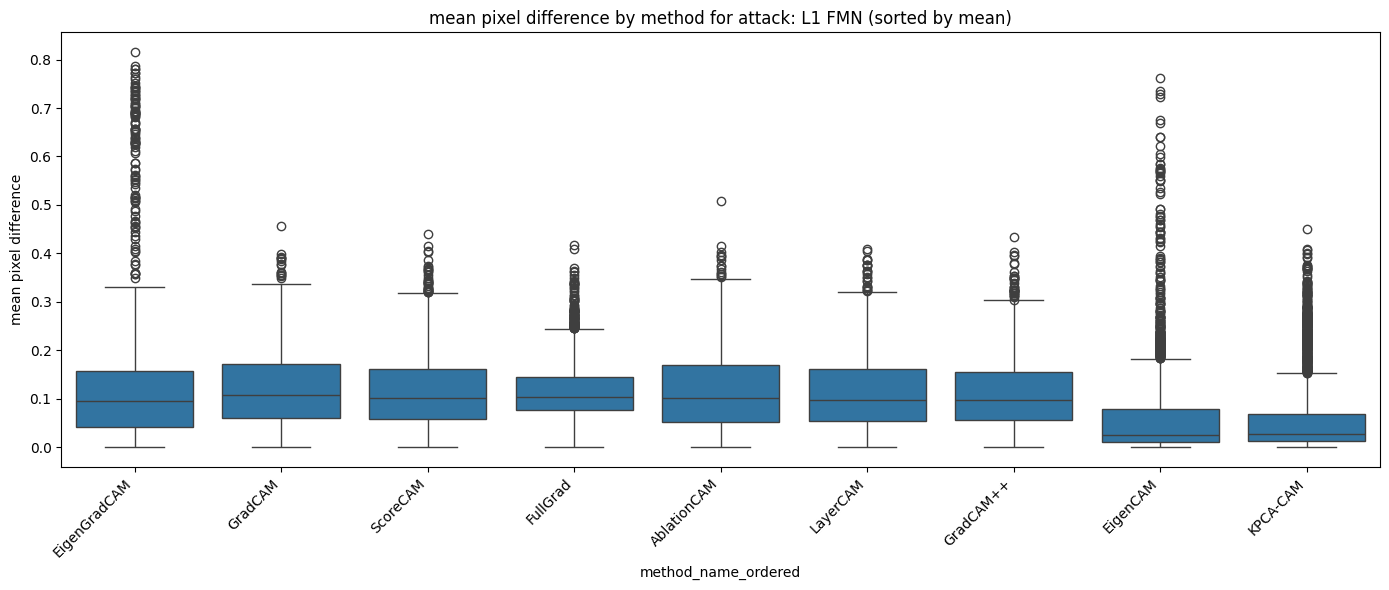

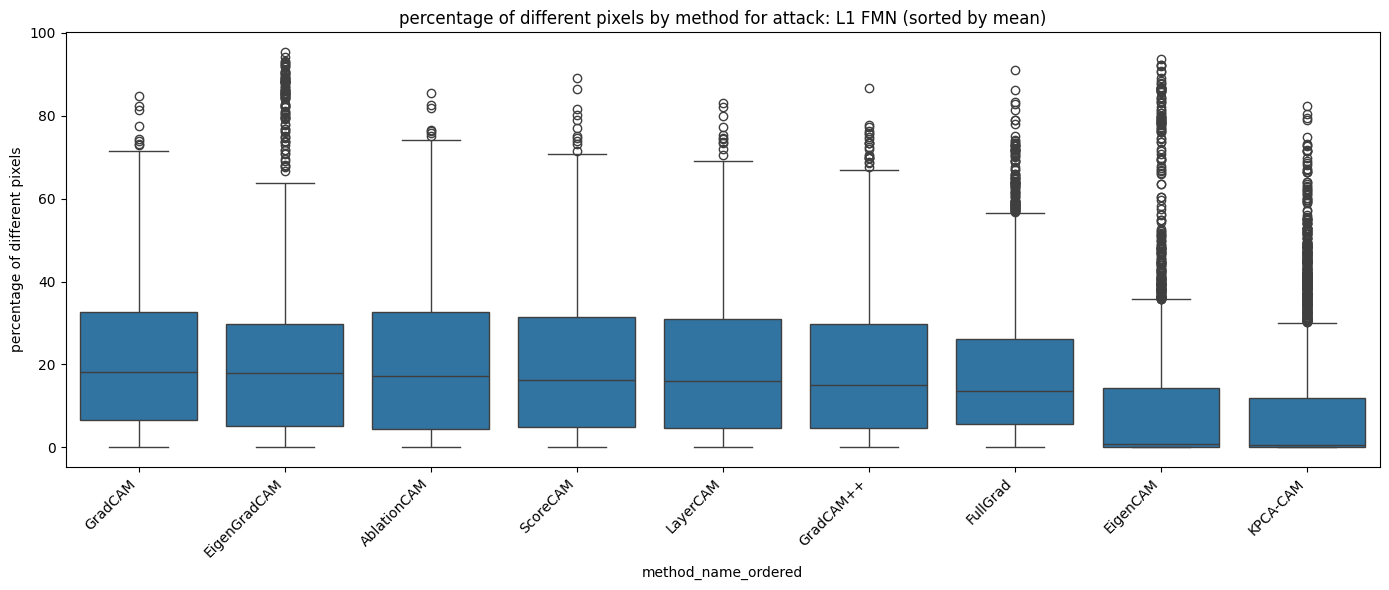

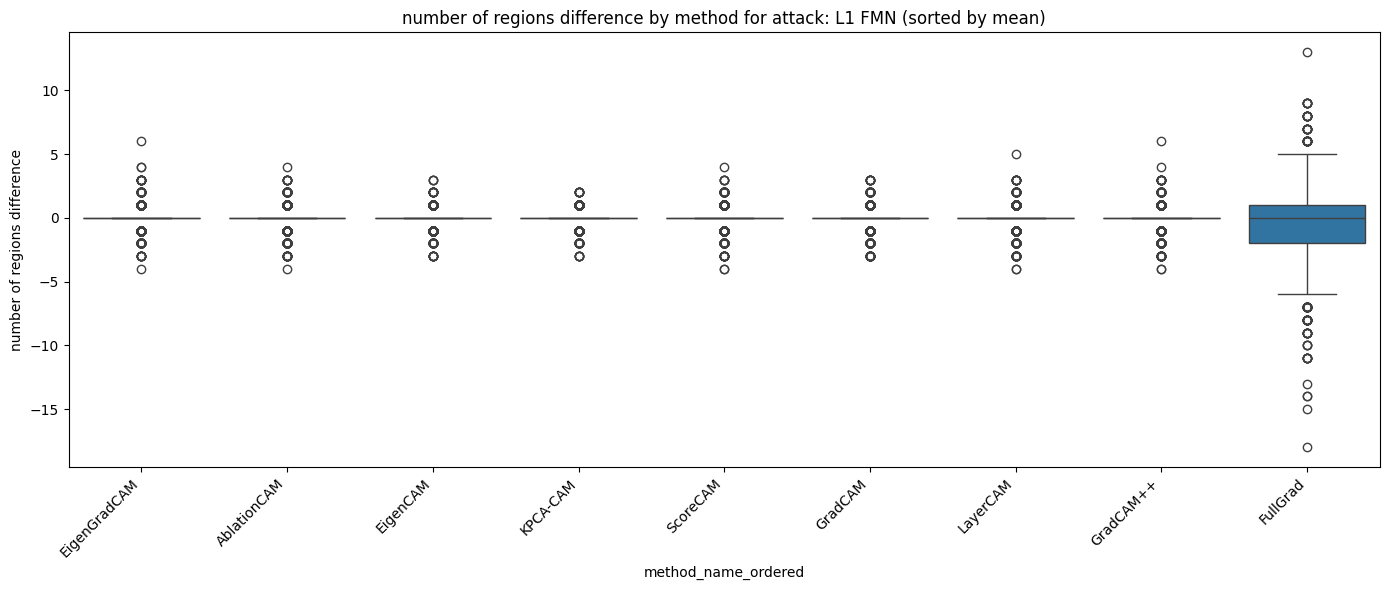

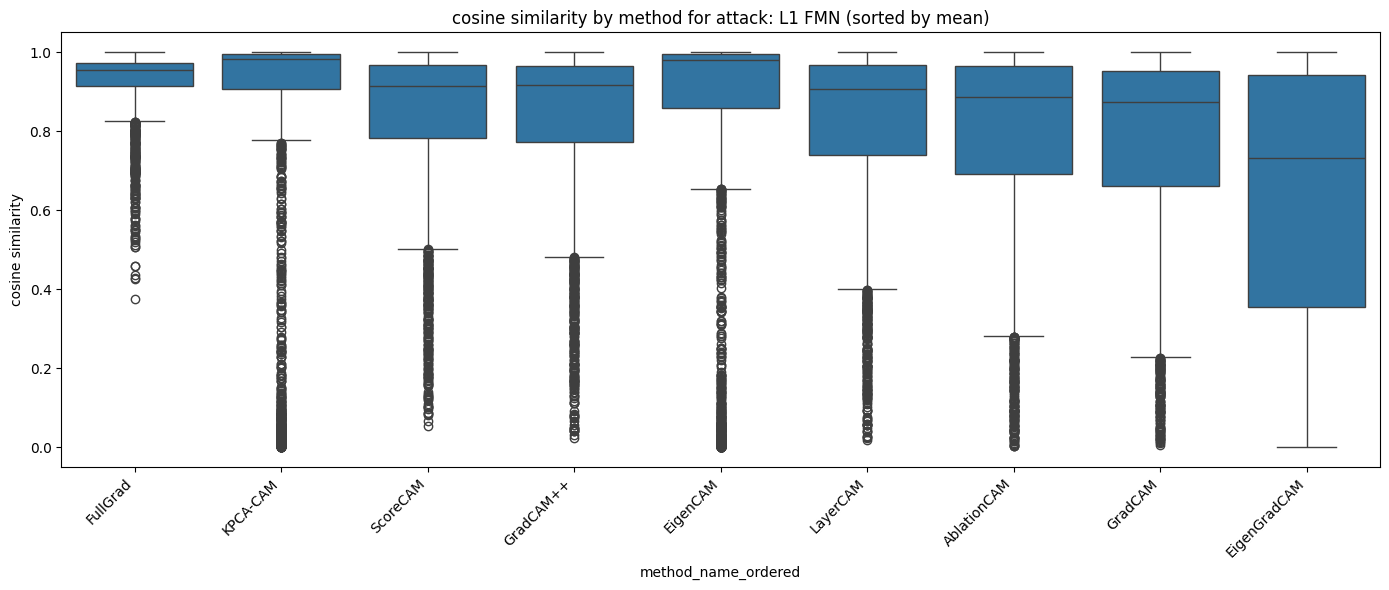

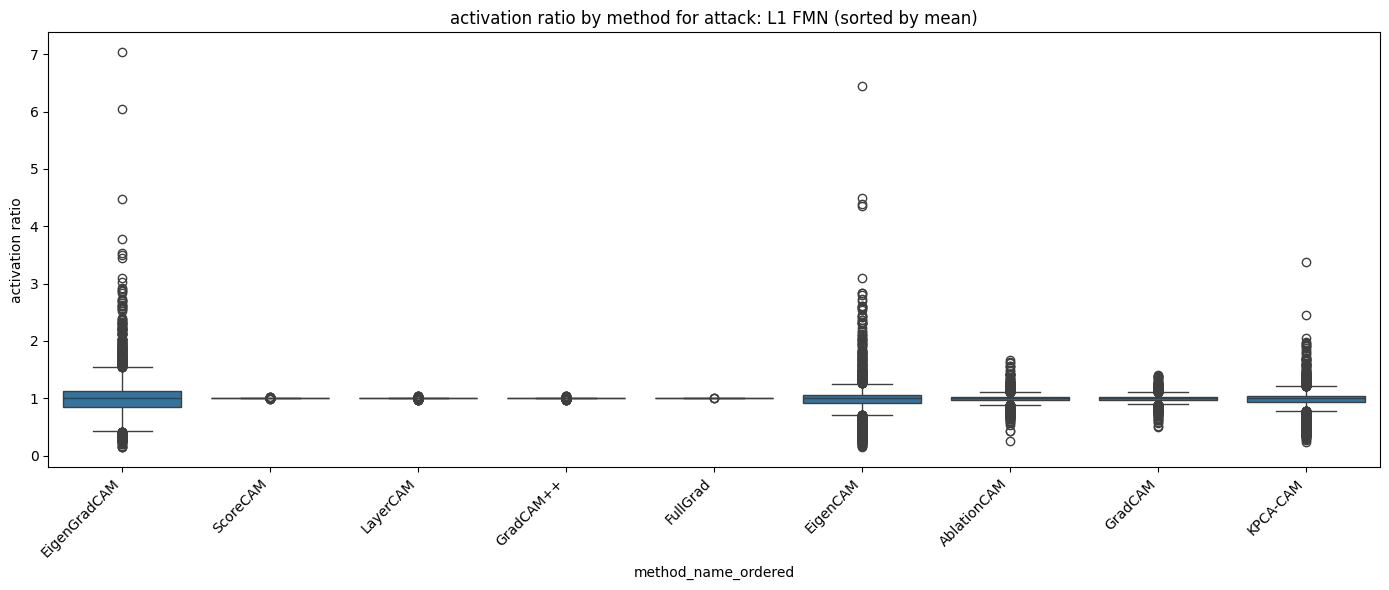

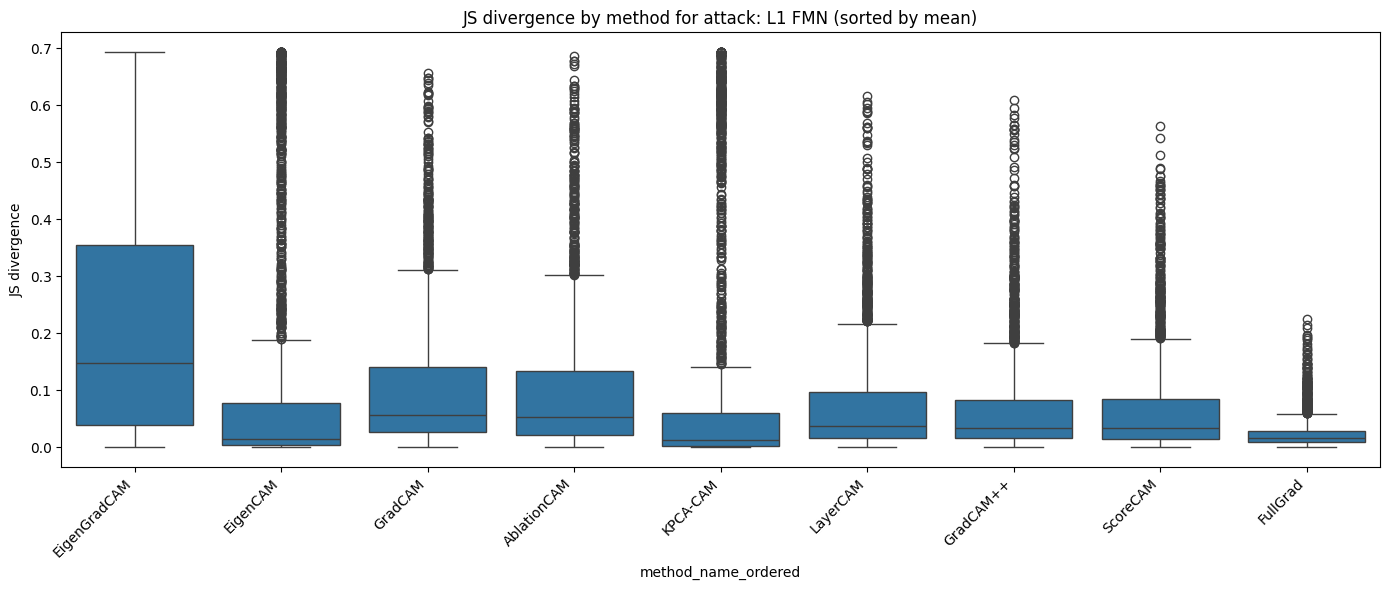

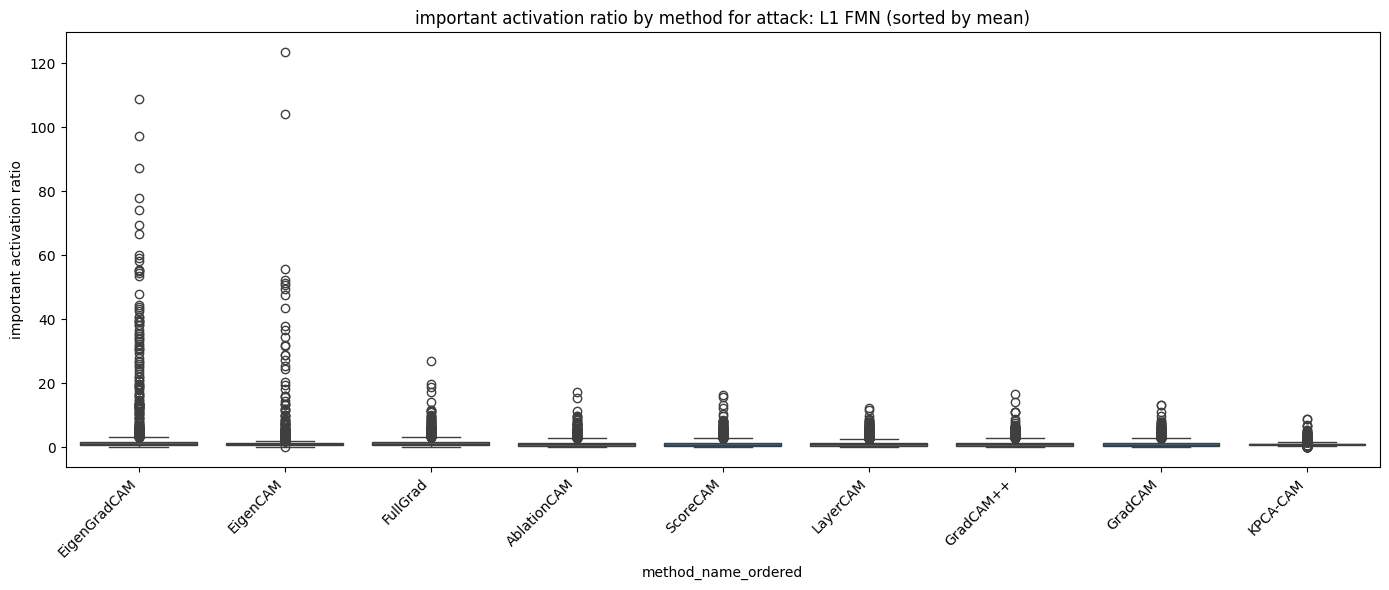

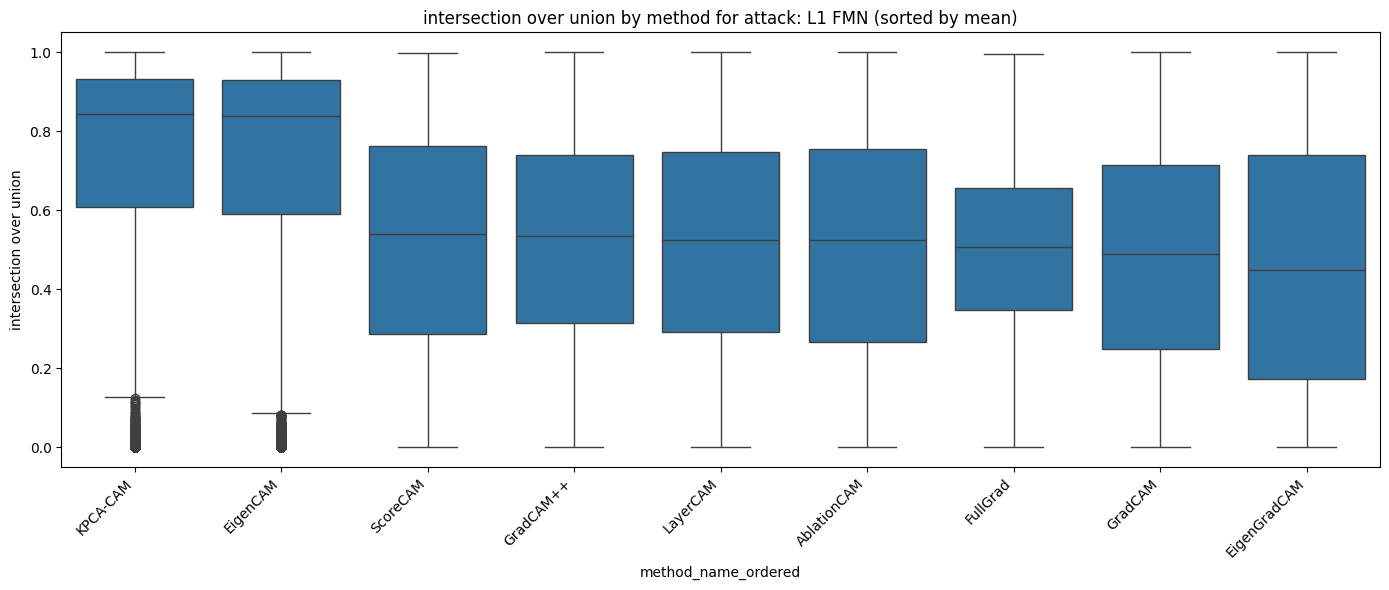

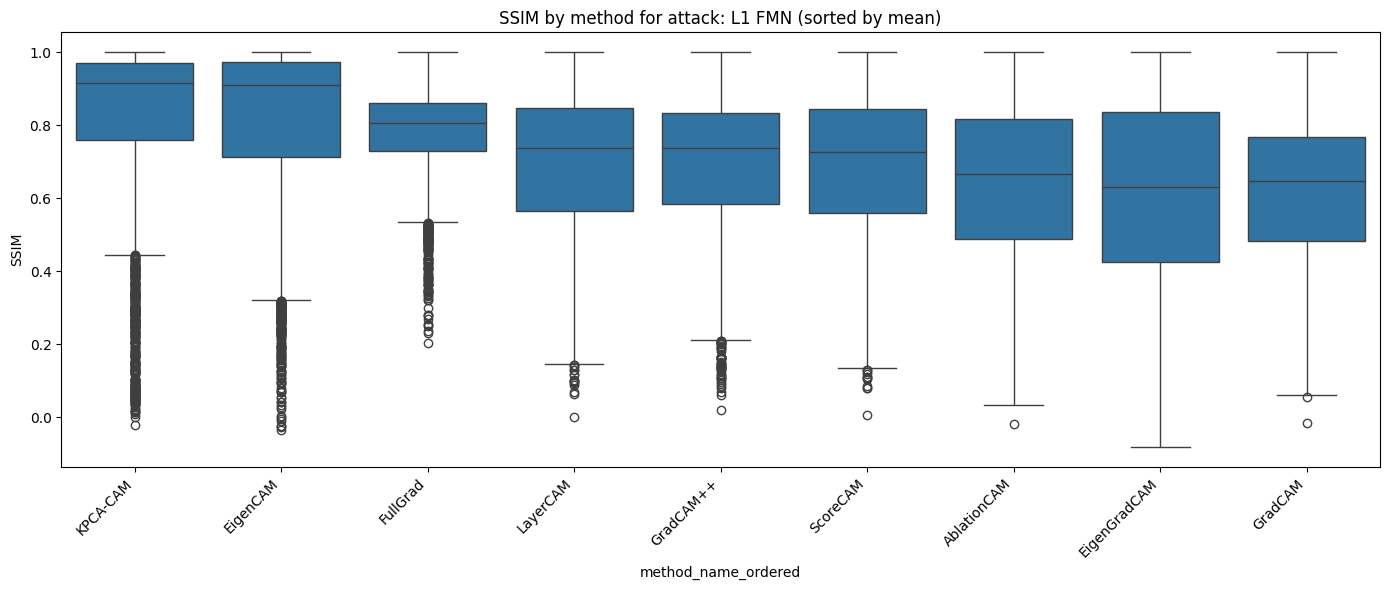

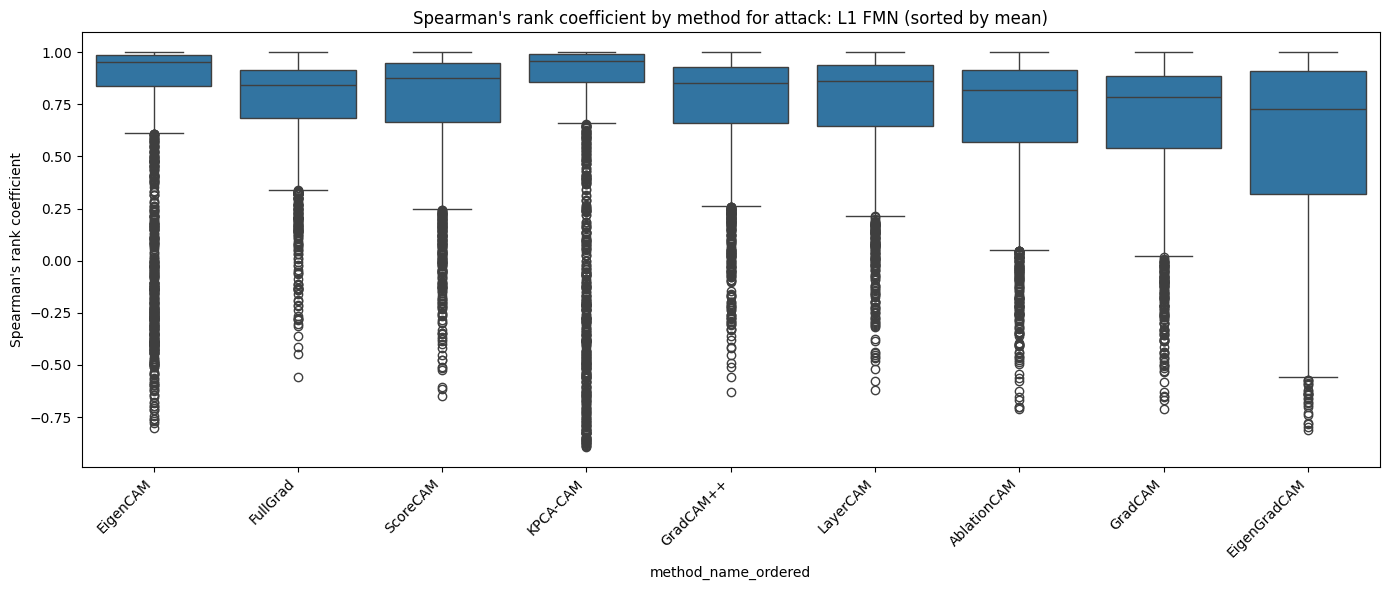

In [23]:
attack_to_plot = "L1 FMN"  # ← replace with your desired attack name

for metric in metric_cols:
    # Filter only rows with the selected attack
    df_filtered = results_df[results_df["attack"] == attack_to_plot].copy()

    # Compute method order based on mean value of the metric
    mean_order = (
        df_filtered.groupby("method")[metric]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # Set ordered categorical for plotting
    df_filtered["method_name_ordered"] = pd.Categorical(
        df_filtered["method"], categories=mean_order, ordered=True
    )

    # Plot
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_filtered, x='method_name_ordered', y=metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{metric} by method for attack: {attack_to_plot} (sorted by mean)')
    plt.tight_layout()
    plt.show()


In [24]:
from scipy.stats import kruskal

results = []

for method in results_df["method"].unique():
    df_method = results_df[results_df["method"] == method]
    
    for metric in metric_cols:
        # Group by attack name
        groups = [group[metric].dropna().values for name, group in df_method.groupby("attack")]
        
        if len(groups) >= 2 and all(len(g) > 0 for g in groups):
            stat, p = kruskal(*groups)
            results.append({
                "method": method,
                "metric": metric,
                "p_value": p,
                "H_statistic": stat
            })

results_df_stats = pd.DataFrame(results)
results_df_stats["significant"] = results_df_stats["p_value"] < 0.05

In [25]:
results_df_stats.sort_values(by="p_value")

,method,metric,p_value,H_statistic,significant
0,GradCAM,mean pixel difference,0.000000e+00,2897.666224,True
59,KPCA-CAM,Spearman's rank coefficient,0.000000e+00,8475.202931,True
58,KPCA-CAM,SSIM,0.000000e+00,9520.550078,True
57,KPCA-CAM,intersection over union,0.000000e+00,8368.730911,True
55,KPCA-CAM,JS divergence,0.000000e+00,9620.104340,True
...,...,...,...,...,...
36,EigenGradCAM,important activation ratio,1.460546e-09,104.122391,True
82,ScoreCAM,number of regions difference,8.449483e-08,92.576629,True
52,KPCA-CAM,number of regions difference,1.754697e-07,90.433315,True
22,EigenCAM,number of regions difference,1.258745e-06,84.532356,True
